## Introduction
In this notebook we'll try to solve quite a challenging task. Using Blog Authorship Corpus which consists of the collected posts of 19,320 bloggers we'll try using solely text of this posts predict the gender, age, zodiac sign and industry of post author. For this I propose to use SentenceTransformers embeddings generated by Siamese BERT-Networks and classifier which is a small Neural Network with two linear layers. Starting with gender prediction model, which I consider the easiest one due to it's binary nature and nice almost ideal balance of classes, I'll proceed to more complex models trying to solve multiclass prediction problems for balanced and non-balanced classes. To speed up computation I'll use GPU, but if GPU is not available on your machine it will automatically compute everything on CPU.

## Content

1. [EDA](#EDA)
2. [Gender model](#Gender-model)
3. [Sign mdoel](#Sign-model)
4. [Age model](#Age-model)
5. [Topic model](#Topic-model)
6. [Summary and alternative approaches](#Summary-and-alternative-approaches)

In [1]:
from model import Model
import pandas as pd
import numpy as np
import torch
pd.options.mode.chained_assignment = None
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pytorch_lightning import loggers as pl_loggers
from sentence_transformers import SentenceTransformer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

comet_ml is installed but `COMET_API_KEY` is not set.


Define device (GPU if available, othervise CPU) and logger for Pytorch Lightning

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
comet_logger = pl_loggers.CometLogger(save_dir='logs/')

CometLogger will be initialized in offline mode


Read the dataset.

In [72]:
df = pd.read_csv('./data/blogtext.csv')
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


## EDA

There are few important things to be noticed during Exploratory Data Analysis in this case. First of all gender and sign are well balanced (classes almost equally distributed). Conversely, age and topic are not-balanced. Text length rarely exceeds threshold of 512 words, which is a cut-off value for BERT. There are records with empty posts. Numerous records have no topic specified.

In [5]:
df.shape

(681284, 7)

In [6]:
df.dtypes

id         int64
gender    object
age        int64
topic     object
sign      object
date      object
text      object
dtype: object

In [7]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [8]:
[(x, len(df[x].unique())) for x in df.columns]

[('id', 19320),
 ('gender', 2),
 ('age', 26),
 ('topic', 40),
 ('sign', 12),
 ('date', 2616),
 ('text', 611652)]

In [9]:
df['text_len'] = df.text.apply(lambda x: len(x.split()))

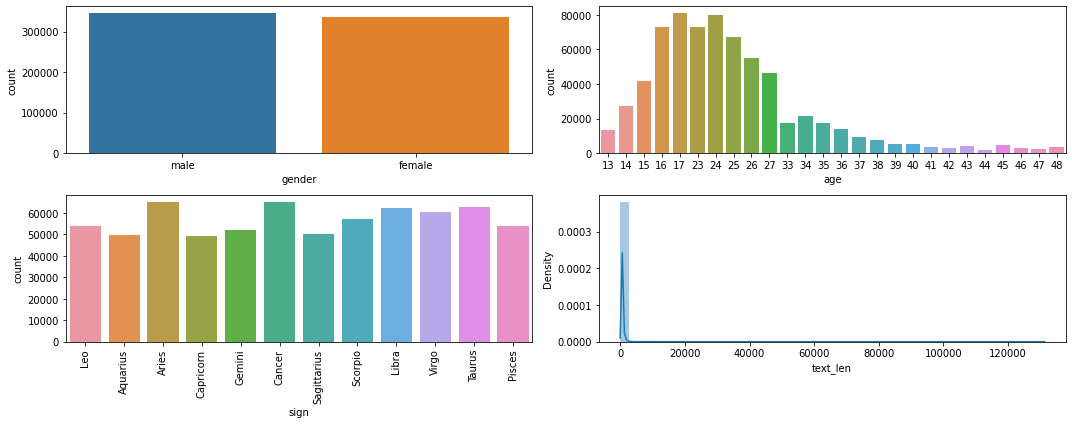

In [10]:
fig, ax = plt.subplots(2, 2, figsize = (15, 6))
sns.countplot(x = df.gender, ax = ax[0][0])
sns.countplot(x = df.age, ax = ax[0][1])
sns.countplot(x = df.sign, ax = ax[1][0])
sns.distplot(a = df.text_len, ax = ax[1][1])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation = 90)
plt.tight_layout();

In [11]:
df.text_len.describe([.85, .9, .95, .99])

count    681284.000000
mean        200.786742
std         415.160622
min           0.000000
50%         112.000000
85%         370.000000
90%         470.000000
95%         663.000000
99%        1257.000000
max      131169.000000
Name: text_len, dtype: float64

In [12]:
df[df.text_len == 0].shape

(3119, 8)

In [13]:
df.topic.value_counts()

indUnk                     251015
Student                    153903
Technology                  42055
Arts                        32449
Education                   29633
Communications-Media        20140
Internet                    16006
Non-Profit                  14700
Engineering                 11653
Law                          9040
Publishing                   7753
Science                      7269
Government                   6907
Consulting                   5862
Religion                     5235
Fashion                      4851
Marketing                    4769
Advertising                  4676
BusinessServices             4500
Banking                      4049
Chemicals                    3928
Telecommunications           3891
Accounting                   3832
Military                     3128
Museums-Libraries            3096
Sports-Recreation            3038
HumanResources               3010
RealEstate                   2870
Transportation               2326
Manufacturing 

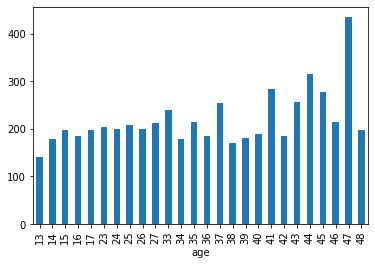

In [14]:
df.groupby('age').text_len.mean().plot(kind = 'bar');

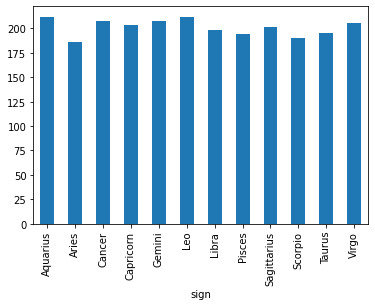

In [15]:
df.groupby('sign').text_len.mean().plot(kind = 'bar');

Let's filter out empty posts. For good practices I create a copy of existent dataset.

In [16]:
data = df[df.text_len > 0].copy()

In [17]:
data.shape

(678165, 8)

Fast preprocessing by lowercasing texts and removing redundant spaces.

In [82]:
def preprocess(text):
    text = text.lower().split()
    return " ".join(text)

In [19]:
%%time
data['prepr_text'] = data.text.apply(lambda x: preprocess(x))

CPU times: user 7.08 s, sys: 264 ms, total: 7.35 s
Wall time: 7.35 s


Let's encode sentences with SentenceTransformer. See doc [here](https://www.sbert.net/). It will take a while. On my machine it took slightly above 2 hours.

In [85]:
st = SentenceTransformer('roberta-base-nli-stsb-mean-tokens').eval()

In [25]:
%%time
data['vectors'] = data.prepr_text.apply(lambda x: st.encode(x))
data.head()

CPU times: user 2h 12min 38s, sys: 5.9 s, total: 2h 12min 43s
Wall time: 2h 12min 49s


,id,gender,age,topic,sign,date,text,text_len,prepr_text,vectors
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",28,"info has been found (+/- 100 pages, and 4.5 mb...","[-0.022713589, -0.03159448, -0.1542669, -0.791..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,20,these are the team members: drewes van der laa...,"[0.42498702, -0.38697943, 0.45772505, 1.349861..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,4326,in het kader van kernfusie op aarde: maak je e...,"[-0.10179597, -0.772578, -0.58268136, -0.31995..."
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,2,testing!!! testing!!!,"[-0.1319768, -0.85336256, 0.3637177, 0.252747,..."
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,65,thanks to yahoo!'s toolbar i can now 'capture'...,"[0.8307138, -0.21023807, -0.4450357, -0.637345..."


To make sure it's still no missings in the dataset.

In [26]:
data.isnull().sum()

id          0
gender      0
age         0
topic       0
sign        0
date        0
text        0
text_len    0
dtype: int64

Saving to pickle to not repeat sentences encoding.

In [27]:
data.to_pickle('./data/blogtext_vec.pkl')

In [4]:
df2 = pd.read_pickle('./data/blogtext_vec.pkl')
df2.head()

,id,gender,age,topic,sign,date,text,text_len,prepr_text,vectors
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",28,"info has been found (+/- 100 pages, and 4.5 mb...","[-0.022713589, -0.03159448, -0.1542669, -0.791..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,20,these are the team members: drewes van der laa...,"[0.42498702, -0.38697943, 0.45772505, 1.349861..."
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,4326,in het kader van kernfusie op aarde: maak je e...,"[-0.10179597, -0.772578, -0.58268136, -0.31995..."
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,2,testing!!! testing!!!,"[-0.1319768, -0.85336256, 0.3637177, 0.252747,..."
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,65,thanks to yahoo!'s toolbar i can now 'capture'...,"[0.8307138, -0.21023807, -0.4450357, -0.637345..."


## Gender model

To convert gender labels to format acceptable by Neural Net we should map it to labels 0 and 1 for `female` and `male` respectively. We create dictionary to map gender values to labels and inverse dictionary to be able to identify which value predicted by the model.

In [5]:
gender_class2idx = {k: v for v, k in enumerate(sorted(df2['gender'].unique()))}
gender_idx2class = {v: k for k, v in gender_class2idx.items()}

In [6]:
gender_class2idx

{'female': 0, 'male': 1}

In [7]:
df2['gender'] = df2['gender'].map(gender_class2idx)

In [8]:
df2.gender.value_counts(normalize = True)

1    0.506509
0    0.493491
Name: gender, dtype: float64

Then we perform split on train, validation and test samples. I do this with two steps, firstly separating test sample, then spliting train and validation.

In [11]:
X = df2['vectors'].values
y = df2['gender'].values

In [12]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

As can be seen stratified split resulted in almost identical share of classes throughout all three samples.

In [34]:
print(np.unique(y_train, return_counts=True)[1]/len(y_train))
print(np.unique(y_val, return_counts=True)[1]/len(y_val))
print(np.unique(y_test, return_counts=True)[1]/len(y_test))

[0.49349083 0.50650917]
[0.49348734 0.50651266]
[0.49349347 0.50650653]


In [35]:
print(X_train.size, X_val.size, X_test.size)

379772 162760 135633


The first run is simple sanity check. We just want to make sure, that there is no serious bug in the code of model implementation.

In [37]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger
}

In [38]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [39]:
%%time
model.fit()

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
INFO:lightning:Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K
INFO:lightning:
  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.99s/it, loss=0.701, v_num=ecee]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

Epoch 0: avg_val_loss reached 0.71426 (best 0.71426), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs.ckpt as top 1
INFO:lightning:Epoch 0: avg_val_loss reached 0.71426 (best 0.71426), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it, loss=0.701, v_num=ecee]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics:
COMET INFO:     avg_train_loss : 0.7012262940406799
COMET INFO:     avg_val_loss   : 0.7142595052719116
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     batch_size   : 32
COMET INFO:     device       : cuda
COMET INFO:     fast_dev_run : True
COMET INFO:     logger       : <pytorch_lightning.loggers.comet.CometLogger object at 0x7ff01ffc18d0>
COMET INFO:     num_workers  : 12
COMET INFO:     pin_memory   : True
COMET INFO:     shuffle      : 1
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (3 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     gi

COMET INFO: Saving offline stats to disk before program termination (may take several seconds)
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/38319611f8f046819643125fefeeecee.zip


CPU times: user 128 ms, sys: 4.56 s, total: 4.68 s
Wall time: 5.58 s


Sanity check went well. Then to make sure NN is learning I try to overfit on small subsaple. And as can be seen below, model does it successfuly.

In [40]:
hparams = {
    'overfit_batches': 1e-3,
    'num_warmup_steps': 0,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'max_epochs': 40,
    'lr': 1e-3,
    'logger': comet_logger,
    'shuffle': False # it's important not to shuffle training samples
}

In [41]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [42]:
%%time
model.fit()

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K
INFO:lightning:
  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  50%|█████     | 11/22 [00:02<00:02,  4.09it/s, loss=0.712, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Epoch 0:  59%|█████▉    | 13/22 [00:05<00:03,  2.43it/s, loss=0.712, v_num=d0c3]

Epoch 0: avg_val_loss reached 0.62183 (best 0.62183), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 0: avg_val_loss reached 0.62183 (best 0.62183), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 1:  55%|█████▍    | 12/22 [00:02<00:01,  5.11it/s, loss=0.649, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:25,  2.58s/it]

Epoch 1: avg_val_loss reached 0.55029 (best 0.55029), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 1: avg_val_loss reached 0.55029 (best 0.55029), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 2:  55%|█████▍    | 12/22 [00:02<00:02,  4.93it/s, loss=0.563, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:26,  2.60s/it]

Epoch 2: avg_val_loss reached 0.46864 (best 0.46864), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 2: avg_val_loss reached 0.46864 (best 0.46864), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 3:  55%|█████▍    | 12/22 [00:02<00:01,  5.88it/s, loss=0.483, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.35s/it]

Epoch 3: avg_val_loss reached 0.38164 (best 0.38164), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 3: avg_val_loss reached 0.38164 (best 0.38164), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 4:  55%|█████▍    | 12/22 [00:02<00:02,  4.95it/s, loss=0.394, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.47s/it]

Epoch 4: avg_val_loss reached 0.29319 (best 0.29319), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 4: avg_val_loss reached 0.29319 (best 0.29319), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 5:  55%|█████▍    | 12/22 [00:02<00:01,  5.40it/s, loss=0.307, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.26s/it]

Epoch 5: avg_val_loss reached 0.21598 (best 0.21598), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 5: avg_val_loss reached 0.21598 (best 0.21598), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 6:  55%|█████▍    | 12/22 [00:02<00:02,  4.43it/s, loss=0.228, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

Epoch 6: avg_val_loss reached 0.15859 (best 0.15859), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 6: avg_val_loss reached 0.15859 (best 0.15859), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 7:  55%|█████▍    | 12/22 [00:02<00:01,  5.06it/s, loss=0.164, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.27s/it]

Epoch 7: avg_val_loss reached 0.11616 (best 0.11616), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 7: avg_val_loss reached 0.11616 (best 0.11616), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 8:  55%|█████▍    | 12/22 [00:02<00:02,  4.62it/s, loss=0.120, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.48s/it]

Epoch 8: avg_val_loss reached 0.08028 (best 0.08028), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 8: avg_val_loss reached 0.08028 (best 0.08028), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 9:  55%|█████▍    | 12/22 [00:02<00:02,  4.80it/s, loss=0.093, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.33s/it]

Epoch 9: avg_val_loss reached 0.07686 (best 0.07686), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 9: avg_val_loss reached 0.07686 (best 0.07686), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 10:  55%|█████▍    | 12/22 [00:02<00:02,  4.41it/s, loss=0.077, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.44s/it]

Epoch 10: avg_val_loss reached 0.06625 (best 0.06625), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 10: avg_val_loss reached 0.06625 (best 0.06625), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 11:  55%|█████▍    | 12/22 [00:02<00:01,  5.10it/s, loss=0.069, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.20s/it]

Epoch 11: avg_val_loss reached 0.04438 (best 0.04438), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 11: avg_val_loss reached 0.04438 (best 0.04438), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 12:  55%|█████▍    | 12/22 [00:02<00:02,  4.79it/s, loss=0.056, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:25,  2.52s/it]

Epoch 12: avg_val_loss reached 0.03461 (best 0.03461), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 12: avg_val_loss reached 0.03461 (best 0.03461), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 13:  55%|█████▍    | 12/22 [00:02<00:01,  5.41it/s, loss=0.039, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:27,  2.77s/it]

Epoch 13: avg_val_loss reached 0.02777 (best 0.02777), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 13: avg_val_loss reached 0.02777 (best 0.02777), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 14:  55%|█████▍    | 12/22 [00:02<00:02,  4.91it/s, loss=0.027, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.37s/it]

Epoch 14: avg_val_loss reached 0.02178 (best 0.02178), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 14: avg_val_loss reached 0.02178 (best 0.02178), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 15:  55%|█████▍    | 12/22 [00:02<00:02,  4.65it/s, loss=0.022, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.40s/it]

Epoch 15: avg_val_loss reached 0.01789 (best 0.01789), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 15: avg_val_loss reached 0.01789 (best 0.01789), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 16:  55%|█████▍    | 12/22 [00:02<00:02,  4.33it/s, loss=0.018, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:27,  2.75s/it]

Epoch 16: avg_val_loss reached 0.01575 (best 0.01575), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 16: avg_val_loss reached 0.01575 (best 0.01575), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 17:  55%|█████▍    | 12/22 [00:02<00:02,  4.22it/s, loss=0.016, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:21,  2.18s/it]

Epoch 17: avg_val_loss reached 0.01420 (best 0.01420), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 17: avg_val_loss reached 0.01420 (best 0.01420), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 18:  55%|█████▍    | 12/22 [00:02<00:01,  5.26it/s, loss=0.014, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.38s/it]

Epoch 18: avg_val_loss reached 0.01299 (best 0.01299), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 18: avg_val_loss reached 0.01299 (best 0.01299), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 19:  55%|█████▍    | 12/22 [00:02<00:02,  4.98it/s, loss=0.013, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:21,  2.13s/it]

Epoch 19: avg_val_loss reached 0.01203 (best 0.01203), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 19: avg_val_loss reached 0.01203 (best 0.01203), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 20:  55%|█████▍    | 12/22 [00:02<00:01,  5.14it/s, loss=0.012, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.49s/it]

Epoch 20: avg_val_loss reached 0.01124 (best 0.01124), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 20: avg_val_loss reached 0.01124 (best 0.01124), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 21:  55%|█████▍    | 12/22 [00:02<00:02,  4.83it/s, loss=0.011, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:23,  2.38s/it]

Epoch 21: avg_val_loss reached 0.01058 (best 0.01058), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 21: avg_val_loss reached 0.01058 (best 0.01058), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 22:  55%|█████▍    | 12/22 [00:02<00:01,  5.12it/s, loss=0.011, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.44s/it]

Epoch 22: avg_val_loss reached 0.01003 (best 0.01003), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 22: avg_val_loss reached 0.01003 (best 0.01003), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 23:  55%|█████▍    | 12/22 [00:02<00:02,  4.75it/s, loss=0.010, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.25s/it]

Epoch 23: avg_val_loss reached 0.00956 (best 0.00956), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 23: avg_val_loss reached 0.00956 (best 0.00956), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 24:  55%|█████▍    | 12/22 [00:02<00:02,  4.88it/s, loss=0.010, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:25,  2.53s/it]

Epoch 24: avg_val_loss reached 0.00917 (best 0.00917), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 24: avg_val_loss reached 0.00917 (best 0.00917), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 25:  55%|█████▍    | 12/22 [00:02<00:02,  4.90it/s, loss=0.009, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.20s/it]

Epoch 25: avg_val_loss reached 0.00884 (best 0.00884), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 25: avg_val_loss reached 0.00884 (best 0.00884), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 26:  55%|█████▍    | 12/22 [00:02<00:01,  5.09it/s, loss=0.009, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:22,  2.26s/it]

Epoch 26: avg_val_loss reached 0.00855 (best 0.00855), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 26: avg_val_loss reached 0.00855 (best 0.00855), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 27:  55%|█████▍    | 12/22 [00:02<00:01,  5.17it/s, loss=0.009, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:24,  2.50s/it]

Epoch 27: avg_val_loss reached 0.00832 (best 0.00832), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 27: avg_val_loss reached 0.00832 (best 0.00832), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 28:  55%|█████▍    | 12/22 [00:02<00:02,  4.74it/s, loss=0.008, v_num=d0c3]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:02<00:27,  2.72s/it]

Epoch 28: avg_val_loss reached 0.00812 (best 0.00812), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1
INFO:lightning:Epoch 28: avg_val_loss reached 0.00812 (best 0.00812), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v0.ckpt as top 1


Epoch 28: 100%|██████████| 22/22 [00:06<00:00,  3.58it/s, loss=0.008, v_num=d0c3]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [29] : (0.008260891772806644, 0.7119700908660889)
COMET INFO:     avg_val_loss [29]   : (0.008115561679005623, 0.6218330264091492)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7ff01e8d2d50>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 40
COMET INFO:     num_warmup_steps : 1
COMET INFO:     num_workers      : 12
COMET INFO:     overfit_batches  : 0.001
COMET INFO:     pin_memory       : True
COMET INFO:     shuffle          : 1

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/89048baa99cd466db01f02611e48d0c3.zip


CPU times: user 2.31 s, sys: 2min 31s, total: 2min 34s
Wall time: 2min 49s


Finally, running the model itself. I specified 2000 warmup steps and learning rate 0.001. Model automatically will stop if validation loss averaged on batches will not reduce for three consecutive epochs at least by 0.001. Additionally it will save the best model in checkpoint folder for us to be able to load it and try on test sample. There are some additional features which are provided by Pytorch Lightning, like learning rate scheduler and different logging possibilities.

In [13]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000
}

In [44]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.
INFO:lightning:EarlyStopping mode set to min for monitoring avg_val_loss.


In [45]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

Let's check the mertics before training. By now model is not better than a random one.

In [46]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 976.79it/s] 

              precision    recall  f1-score   support

           0      0.493     0.995     0.660     66934
           1      0.445     0.004     0.007     68699

    accuracy                          0.493    135633
   macro avg      0.469     0.499     0.333    135633
weighted avg      0.469     0.493     0.329    135633



In [47]:
%%time
model.fit()

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: False, using: 0 TPU cores
INFO:lightning:TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K
INFO:lightning:
  | Name | Type | Params
------------------------------
0 | net  | Net  | 98.7 K


Epoch 0:  70%|██████▉   | 11868/16955 [01:17<00:33, 153.19it/s, loss=0.637, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5055/5087 [00:08<00:00, 822.22it/s]

Epoch 0: avg_val_loss reached 0.63463 (best 0.63463), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 0: avg_val_loss reached 0.63463 (best 0.63463), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:51<00:21, 231.81it/s, loss=0.643, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█████████▉| 16915/16955 [00:59<00:00, 284.26it/s, loss=0.643, v_num=cba1]

Epoch 1: avg_val_loss reached 0.62691 (best 0.62691), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1
INFO:lightning:Epoch 1: avg_val_loss reached 0.62691 (best 0.62691), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:51<00:22, 229.39it/s, loss=0.639, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5063/5087 [00:08<00:00, 832.54it/s]

Epoch 2: avg_val_loss reached 0.62482 (best 0.62482), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1
INFO:lightning:Epoch 2: avg_val_loss reached 0.62482 (best 0.62482), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:51<00:21, 231.53it/s, loss=0.627, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5080/5087 [00:08<00:00, 835.94it/s]

Epoch 3: avg_val_loss was not in top 1
INFO:lightning:Epoch 3: avg_val_loss was not in top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:53<00:22, 223.13it/s, loss=0.623, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 16910/16955 [01:01<00:00, 274.52it/s, loss=0.623, v_num=cba1]

Epoch 4: avg_val_loss was not in top 1
INFO:lightning:Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:52<00:22, 226.84it/s, loss=0.624, v_num=cba1]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5043/5087 [00:08<00:00, 825.85it/s]

Epoch 5: avg_val_loss reached 0.62406 (best 0.62406), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1
INFO:lightning:Epoch 5: avg_val_loss reached 0.62406 (best 0.62406), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v2.ckpt as top 1


Epoch 5: 100%|██████████| 16955/16955 [01:01<00:00, 274.40it/s, loss=0.624, v_num=cba1]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [6] : (0.6114363074302673, 0.637794554233551)
COMET INFO:     avg_val_loss [6]   : (0.6240603923797607, 0.6346268653869629)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7ff0047cfa50>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 30
COMET INFO:     num_warmup_steps : 2000
COMET INFO:     num_workers      : 12
COMET INFO:     pin_memory       : True
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (4 KB)
COMET 

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/f304a24d2a8845ac8be91257f62ecba1.zip


CPU times: user 5min 56s, sys: 1min 19s, total: 7min 16s
Wall time: 6min 39s


Let's load the best model from checkpoint and see quite a good performance. The model is able to predict blogger's gender quite successfuly. All metrics are above 60%, F1 score is apx. 65%. 

In [14]:
gender_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams,\
                                   checkpoint_path="./checkpoints/model-outputs-v2.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.


In [15]:
gender_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [16]:
pred = gender_model.predict_eval(X_test , y_test)

100%|██████████| 4239/4239 [00:03<00:00, 1100.71it/s]


              precision    recall  f1-score   support

           0      0.636     0.675     0.655     66934
           1      0.663     0.624     0.643     68699

    accuracy                          0.649    135633
   macro avg      0.650     0.649     0.649    135633
weighted avg      0.650     0.649     0.649    135633



## Sign model

Let's proceed with more challenging model. Multiclass classification task - sign prediciton. As previously, classes are well balanced. Let's create label mapping.

In [17]:
sign_class2idx = {k: v for v, k in enumerate(sorted(df2['sign'].unique()))}
sign_idx2class = {v: k for k, v in sign_class2idx.items()}

In [18]:
sign_class2idx

{'Aquarius': 0,
 'Aries': 1,
 'Cancer': 2,
 'Capricorn': 3,
 'Gemini': 4,
 'Leo': 5,
 'Libra': 6,
 'Pisces': 7,
 'Sagittarius': 8,
 'Scorpio': 9,
 'Taurus': 10,
 'Virgo': 11}

In [19]:
df2['sign'] = df2['sign'].map(sign_class2idx)

Exactly the same stratified samples splitting.

In [20]:
X = df2['vectors'].values
y = df2['sign'].values

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

Sanity check and overfitting on small subsample.

In [22]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger
}

In [47]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [48]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=2.513, v_num=c394]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

Epoch 0: avg_val_loss reached 2.46879 (best 2.46879), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v1.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it, loss=2.513, v_num=c394]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics:
COMET INFO:     avg_train_loss : 2.5129876136779785
COMET INFO:     avg_val_loss   : 2.4687867164611816
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     batch_size   : 32
COMET INFO:     device       : cuda
COMET INFO:     fast_dev_run : True
COMET INFO:     logger       : <pytorch_lightning.loggers.comet.CometLogger object at 0x7fccf8f29e10>
COMET INFO:     num_workers  : 12
COMET INFO:     pin_memory   : True
COMET INFO:     shuffle      : 1
COMET INFO:   Uploads:
COMET INFO:     code                     : 1 (4 KB)
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     gi

COMET INFO: Saving offline stats to disk before program termination (may take several seconds)
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/e92c34b9d1da4e789aefb832f6b3c394.zip


CPU times: user 153 ms, sys: 2.86 s, total: 3.01 s
Wall time: 4.65 s


In [23]:
hparams = {
    'overfit_batches': 1e-3,
    'num_warmup_steps': 0,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'max_epochs': 40,
    'lr': 1e-3,
    'logger': comet_logger,
    'shuffle': False # it's important not to shuffle training samples
}

In [50]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [51]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  50%|█████     | 11/22 [00:01<00:01,  8.42it/s, loss=2.501, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Epoch 0:  59%|█████▉    | 13/22 [00:02<00:01,  4.81it/s, loss=2.501, v_num=8b64]

Epoch 0: avg_val_loss reached 2.26077 (best 2.26077), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 1:  55%|█████▍    | 12/22 [00:01<00:01,  8.93it/s, loss=2.336, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.34s/it]

Epoch 1: avg_val_loss reached 2.04526 (best 2.04526), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 2:  55%|█████▍    | 12/22 [00:01<00:01,  8.75it/s, loss=2.097, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Epoch 2: avg_val_loss reached 1.84470 (best 1.84470), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 3:  55%|█████▍    | 12/22 [00:01<00:00, 10.48it/s, loss=1.896, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.33s/it]

Epoch 3: avg_val_loss reached 1.65575 (best 1.65575), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 4:  55%|█████▍    | 12/22 [00:01<00:01,  8.84it/s, loss=1.707, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.34s/it]

Epoch 4: avg_val_loss reached 1.47650 (best 1.47650), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 5:  55%|█████▍    | 12/22 [00:01<00:01,  8.56it/s, loss=1.528, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.28s/it]

Epoch 5: avg_val_loss reached 1.30708 (best 1.30708), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 6:  55%|█████▍    | 12/22 [00:01<00:01,  7.77it/s, loss=1.358, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.51s/it]

Epoch 6: avg_val_loss reached 1.14775 (best 1.14775), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 7:  55%|█████▍    | 12/22 [00:01<00:01,  8.43it/s, loss=1.199, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Epoch 7: avg_val_loss reached 0.99997 (best 0.99997), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 8:  55%|█████▍    | 12/22 [00:01<00:01,  8.03it/s, loss=1.050, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.43s/it]

Epoch 8: avg_val_loss reached 0.86352 (best 0.86352), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 9:  55%|█████▍    | 12/22 [00:01<00:01,  9.25it/s, loss=0.912, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.60s/it]

Epoch 9: avg_val_loss reached 0.73956 (best 0.73956), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 10:  55%|█████▍    | 12/22 [00:01<00:01,  9.12it/s, loss=0.786, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.17s/it]

Epoch 10: avg_val_loss reached 0.62882 (best 0.62882), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 11:  55%|█████▍    | 12/22 [00:01<00:00, 10.02it/s, loss=0.672, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.20s/it]

Epoch 11: avg_val_loss reached 0.53151 (best 0.53151), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 12:  55%|█████▍    | 12/22 [00:01<00:01,  9.01it/s, loss=0.570, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.19s/it]

Epoch 12: avg_val_loss reached 0.44676 (best 0.44676), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 13:  55%|█████▍    | 12/22 [00:01<00:01,  8.55it/s, loss=0.481, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.54s/it]

Epoch 13: avg_val_loss reached 0.37490 (best 0.37490), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 14:  55%|█████▍    | 12/22 [00:01<00:01,  7.71it/s, loss=0.404, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.32s/it]

Epoch 14: avg_val_loss reached 0.31447 (best 0.31447), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 15:  55%|█████▍    | 12/22 [00:01<00:01,  8.41it/s, loss=0.339, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.46s/it]

Epoch 15: avg_val_loss reached 0.26438 (best 0.26438), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 16:  55%|█████▍    | 12/22 [00:01<00:01,  9.24it/s, loss=0.285, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.47s/it]

Epoch 16: avg_val_loss reached 0.22428 (best 0.22428), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 17:  55%|█████▍    | 12/22 [00:01<00:01,  9.92it/s, loss=0.241, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.37s/it]

Epoch 17: avg_val_loss reached 0.19147 (best 0.19147), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 18:  55%|█████▍    | 12/22 [00:01<00:01,  8.95it/s, loss=0.205, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.16s/it]

Epoch 18: avg_val_loss reached 0.16570 (best 0.16570), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 19:  55%|█████▍    | 12/22 [00:01<00:01,  9.64it/s, loss=0.176, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.26s/it]

Epoch 19: avg_val_loss reached 0.14479 (best 0.14479), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 20:  55%|█████▍    | 12/22 [00:01<00:01,  8.05it/s, loss=0.153, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.19s/it]

Epoch 20: avg_val_loss reached 0.12832 (best 0.12832), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 21:  55%|█████▍    | 12/22 [00:01<00:01,  9.95it/s, loss=0.135, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.46s/it]

Epoch 21: avg_val_loss reached 0.11493 (best 0.11493), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 22:  55%|█████▍    | 12/22 [00:01<00:01,  7.99it/s, loss=0.120, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.33s/it]

Epoch 22: avg_val_loss reached 0.10431 (best 0.10431), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 23:  55%|█████▍    | 12/22 [00:01<00:01,  8.61it/s, loss=0.108, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.35s/it]

Epoch 23: avg_val_loss reached 0.09566 (best 0.09566), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 24:  55%|█████▍    | 12/22 [00:01<00:01,  9.11it/s, loss=0.099, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.35s/it]

Epoch 24: avg_val_loss reached 0.08865 (best 0.08865), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 25:  55%|█████▍    | 12/22 [00:01<00:01,  8.74it/s, loss=0.091, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.45s/it]

Epoch 25: avg_val_loss reached 0.08302 (best 0.08302), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 26:  55%|█████▍    | 12/22 [00:01<00:01,  9.79it/s, loss=0.085, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:16,  1.69s/it]

Epoch 26: avg_val_loss reached 0.07848 (best 0.07848), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 27:  55%|█████▍    | 12/22 [00:01<00:01,  7.96it/s, loss=0.080, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.38s/it]

Epoch 27: avg_val_loss reached 0.07485 (best 0.07485), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 28:  55%|█████▍    | 12/22 [00:01<00:01,  8.54it/s, loss=0.076, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

Epoch 28: avg_val_loss reached 0.07193 (best 0.07193), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 29:  55%|█████▍    | 12/22 [00:01<00:01,  7.79it/s, loss=0.073, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.34s/it]

Epoch 29: avg_val_loss reached 0.06959 (best 0.06959), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 30:  55%|█████▍    | 12/22 [00:01<00:01,  8.20it/s, loss=0.071, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:13,  1.31s/it]

Epoch 30: avg_val_loss reached 0.06772 (best 0.06772), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 31:  55%|█████▍    | 12/22 [00:01<00:01,  9.42it/s, loss=0.069, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.30s/it]

Epoch 31: avg_val_loss reached 0.06625 (best 0.06625), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 32:  55%|█████▍    | 12/22 [00:01<00:01,  8.03it/s, loss=0.067, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

Epoch 32: avg_val_loss reached 0.06510 (best 0.06510), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 33:  55%|█████▍    | 12/22 [00:01<00:01,  7.40it/s, loss=0.066, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:15,  1.52s/it]

Epoch 33: avg_val_loss reached 0.06424 (best 0.06424), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 34:  55%|█████▍    | 12/22 [00:01<00:01,  8.56it/s, loss=0.065, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.44s/it]

Epoch 34: avg_val_loss reached 0.06360 (best 0.06360), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 35:  55%|█████▍    | 12/22 [00:01<00:01,  9.42it/s, loss=0.064, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.50s/it]

Epoch 35: avg_val_loss reached 0.06316 (best 0.06316), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 36:  55%|█████▍    | 12/22 [00:01<00:01,  8.90it/s, loss=0.064, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:11,  1.16s/it]

Epoch 36: avg_val_loss reached 0.06288 (best 0.06288), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 37:  55%|█████▍    | 12/22 [00:01<00:01,  9.46it/s, loss=0.063, v_num=8b64]
Validating: 0it [00:00, ?it/s]
Validating:   9%|▉         | 1/11 [00:01<00:14,  1.46s/it]

Epoch 37: avg_val_loss reached 0.06271 (best 0.06271), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v4.ckpt as top 1


Epoch 37: 100%|██████████| 22/22 [00:03<00:00,  6.68it/s, loss=0.063, v_num=8b64]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [38] : (0.06283894926309586, 2.500877857208252)
COMET INFO:     avg_val_loss [38]   : (0.0627129077911377, 2.2607719898223877)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7fcccc594490>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 40
COMET INFO:     num_warmup_steps : 1
COMET INFO:     num_workers      : 12
COMET INFO:     overfit_batches  : 0.001
COMET INFO:     pin_memory       : True
COMET INFO:     shuffle          : 1
COM

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/38719e5890a149899e4329f225288b64.zip


CPU times: user 5.28 s, sys: 1min 48s, total: 1min 54s
Wall time: 2min 7s


Let's add a dropout this time.

In [24]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2
}

In [53]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [54]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=12, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

Trditionally checking metrics before learning.

In [55]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1054.51it/s]


              precision    recall  f1-score   support

           0      0.076     0.018     0.029      9893
           1      0.096     0.116     0.105     12961
           2      0.097     0.082     0.089     12949
           3      0.060     0.006     0.011      9801
           4      0.076     0.343     0.125     10344
           5      0.072     0.015     0.025     10708
           6      0.107     0.001     0.002     12412
           7      0.079     0.296     0.125     10757
           8      0.095     0.001     0.002      9963
           9      0.119     0.001     0.001     11370
          10      0.090     0.002     0.004     12453
          11      0.090     0.121     0.103     12022

    accuracy                          0.083    135633
   macro avg      0.088     0.084     0.052    135633
weighted avg      0.089     0.083     0.053    135633



In [56]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params 
-------------------------------
0 | net  | Net  | 100.0 K


Epoch 0:  70%|██████▉   | 11868/16955 [00:52<00:22, 225.79it/s, loss=2.480, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5046/5087 [00:07<00:00, 820.70it/s]

Epoch 0: avg_val_loss reached 2.46403 (best 2.46403), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:53<00:22, 222.24it/s, loss=2.466, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5065/5087 [00:07<00:00, 830.68it/s]

Epoch 1: avg_val_loss reached 2.45847 (best 2.45847), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.31it/s, loss=2.462, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5051/5087 [00:07<00:00, 788.71it/s]

Epoch 2: avg_val_loss reached 2.45708 (best 2.45708), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:54<00:23, 218.29it/s, loss=2.461, v_num=5073]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 16900/16955 [01:01<00:00, 272.97it/s, loss=2.461, v_num=5073]

Epoch 3: avg_val_loss reached 2.45388 (best 2.45388), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:55<00:23, 215.24it/s, loss=2.455, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5056/5087 [00:07<00:00, 798.39it/s]

Epoch 4: avg_val_loss reached 2.45364 (best 2.45364), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v3.ckpt as top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:54<00:23, 218.09it/s, loss=2.455, v_num=5073]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 16900/16955 [01:02<00:00, 272.26it/s, loss=2.455, v_num=5073]

Epoch 5: avg_val_loss reached 2.45259 (best 2.45259), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v5.ckpt as top 1


Epoch 6:  70%|██████▉   | 11868/16955 [00:52<00:22, 226.35it/s, loss=2.450, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5052/5087 [00:07<00:00, 780.39it/s]

Epoch 6: avg_val_loss was not in top 1


Epoch 7:  70%|██████▉   | 11868/16955 [00:53<00:22, 221.50it/s, loss=2.455, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5037/5087 [00:07<00:00, 789.18it/s]

Epoch 7: avg_val_loss was not in top 1


Epoch 8:  70%|██████▉   | 11868/16955 [00:52<00:22, 224.23it/s, loss=2.445, v_num=5073]
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 5065/5087 [00:07<00:00, 766.09it/s]

Epoch 8: avg_val_loss was not in top 1


Epoch 8: 100%|██████████| 16955/16955 [01:01<00:00, 275.21it/s, loss=2.445, v_num=5073]

COMET INFO: ----------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ----------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     avg_train_loss [9] : (2.437842607498169, 2.472731828689575)
COMET INFO:     avg_val_loss [9]   : (2.452589988708496, 2.464033603668213)
COMET INFO:   Others:
COMET INFO:     offline_experiment : True
COMET INFO:   Parameters:
COMET INFO:     device           : cuda
COMET INFO:     dropout          : 0.2
COMET INFO:     logger           : <pytorch_lightning.loggers.comet.CometLogger object at 0x7fccf8f29dd0>
COMET INFO:     lr               : 0.001
COMET INFO:     max_epochs       : 30
COMET INFO:     num_warmup_steps : 2000
COMET INFO:     num_workers      : 12
COMET INFO:     pin_memory       : True
COMET INFO:   Uploads:
COMET INFO:     code  

COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/8bbdd26a46a9480e9e4e44383f6e5073.zip


CPU times: user 9min 18s, sys: 1min 39s, total: 10min 57s
Wall time: 9min 24s


In [25]:
sign_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams,\
                                   checkpoint_path="./checkpoints/model-outputs-v5.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.


In [26]:
sign_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=12, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [27]:
pred = sign_model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:03<00:00, 1075.74it/s]

              precision    recall  f1-score   support

           0      0.157     0.073     0.100      9893
           1      0.188     0.094     0.126     12961
           2      0.173     0.108     0.133     12949
           3      0.296     0.011     0.021      9801
           4      0.498     0.012     0.022     10344
           5      0.570     0.022     0.042     10708
           6      0.094     0.838     0.170     12412
           7      0.211     0.034     0.059     10757
           8      0.208     0.006     0.012      9963
           9      0.191     0.027     0.047     11370
          10      0.392     0.018     0.035     12453
          11      0.182     0.014     0.025     12022

    accuracy                          0.113    135633
   macro avg      0.263     0.105     0.066    135633
weighted avg      0.259     0.113     0.069    135633



Metrics are higher now, but still, the model is weak. To be fair, the task sounds a bit impossible, considering that it's hard to find any patterns which are specific for zodiac signs, especially in texts. 

## Age model

Now it's turn for age prediction model. Classes are not balanced, we'll try to deal with it. Repeating again prepararion routine.

In [28]:
age_class2idx = {k: v for v, k in enumerate(sorted(df2['age'].unique()))}
age_idx2class = {v: k for k, v in age_class2idx.items()}

In [29]:
age_class2idx

{13: 0,
 14: 1,
 15: 2,
 16: 3,
 17: 4,
 23: 5,
 24: 6,
 25: 7,
 26: 8,
 27: 9,
 33: 10,
 34: 11,
 35: 12,
 36: 13,
 37: 14,
 38: 15,
 39: 16,
 40: 17,
 41: 18,
 42: 19,
 43: 20,
 44: 21,
 45: 22,
 46: 23,
 47: 24,
 48: 25}

In [30]:
df2['age'] = df2['age'].map(age_class2idx)

In [31]:
X = df2['vectors'].values
y = df2['age'].values

In [32]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

As classes are highly disbalanced we want artificially increase number of times NN sees rare classes. So I provide weights for training instances to activate `WeightedRandomSampler`.

In [33]:
def get_class_distribution(y_label):
    return dict(df2[y_label].value_counts().sort_index())

In [34]:
target_list = torch.tensor(y_train)

In [35]:
class_count = [i for i in get_class_distribution('age').values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

In [36]:
class_weights_all = class_weights[target_list]

In [37]:
class_weights_all

tensor([4.6968e-05, 2.3787e-04, 7.6728e-05,  ..., 1.3801e-05, 1.2532e-05,
        2.1786e-05])

In [38]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger,
    'weights': class_weights_all
}

In [39]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [40]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 101 K 


Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.55s/it, loss=3.297, v_num=324d]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Epoch 0: avg_val_loss reached 3.29605 (best 3.29605), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v7.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.65s/it, loss=3.297, v_num=324d]


COMET INFO: Saving offline stats to disk before program termination (may take several seconds)
COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/8b08f162e2d844b2b226fc7cdd1a324d.zip


CPU times: user 4.17 s, sys: 2.61 s, total: 6.78 s
Wall time: 7.85 s


In [41]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2,
    'weights': class_weights_all,
    'class_weights': class_weights
}

In [42]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [43]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=26, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [44]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:03<00:00, 1110.54it/s]
/home/payonear/Cases_recruit/netguru-case/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.021     0.066     0.032      2607
           1      0.035     0.169     0.057      5456
           2      0.086     0.005     0.010      8314
           3      0.119     0.016     0.028     14492
           4      0.129     0.002     0.004     16107
           5      0.104     0.002     0.004     14493
           6      0.115     0.000     0.000     15959
           7      0.096     0.009     0.017     13348
           8      0.073     0.013     0.023     11014
           9      0.068     0.036     0.048      9180
          10      0.027     0.002     0.004      3498
          11      0.036     0.018     0.024      4258
          12      0.026     0.103     0.041      3481
          13      0.020     0.022     0.021      2835
          14      0.013     0.127     0.023      1853
          15      0.009     0.001     0.001      1484
          16      0.006     0.017     0.009      1092
          17      0.009    

In [45]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 101 K 


Epoch 0:  70%|██████▉   | 11868/16955 [00:54<00:23, 217.79it/s, loss=2.771, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5037/5087 [00:07<00:00, 809.76it/s]

Epoch 0: avg_val_loss reached 2.99739 (best 2.99739), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v8.ckpt as top 1


Epoch 1:  70%|██████▉   | 11868/16955 [00:55<00:23, 215.72it/s, loss=2.489, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5051/5087 [00:07<00:00, 798.73it/s]

Epoch 1: avg_val_loss reached 2.89196 (best 2.89196), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v9.ckpt as top 1


Epoch 2:  70%|██████▉   | 11868/16955 [00:54<00:23, 218.21it/s, loss=2.514, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Validating:  99%|█████████▉| 5048/5087 [00:07<00:00, 778.44it/s]

Epoch 2: avg_val_loss was not in top 1


Epoch 3:  70%|██████▉   | 11868/16955 [00:54<00:23, 216.66it/s, loss=2.532, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█████████▉| 16954/16955 [01:02<00:00, 271.30it/s, loss=2.532, v_num=8cdd]

Epoch 3: avg_val_loss reached 2.85683 (best 2.85683), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v8.ckpt as top 1


Epoch 4:  70%|██████▉   | 11868/16955 [00:54<00:23, 215.79it/s, loss=2.494, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 16954/16955 [01:02<00:00, 270.30it/s, loss=2.494, v_num=8cdd]

Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 11868/16955 [00:54<00:23, 215.83it/s, loss=2.382, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 16954/16955 [01:02<00:00, 270.57it/s, loss=2.382, v_num=8cdd]

Epoch 5: avg_val_loss was not in top 1


Epoch 6:  70%|██████▉   | 11868/16955 [00:55<00:23, 213.89it/s, loss=2.348, v_num=8cdd]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 16954/16955 [01:03<00:00, 267.31it/s, loss=2.348, v_num=8cdd]

Epoch 6: avg_val_loss was not in top 1


Epoch 6: 100%|██████████| 16955/16955 [01:04<00:00, 263.28it/s, loss=2.348, v_num=8cdd]

COMET INFO: Starting saving the offline archive


COMET INFO: To upload this offline experiment, run:
    comet upload logs/29e71d43977b4b718b5a0fec6f2c8cdd.zip


CPU times: user 7min 30s, sys: 1min 12s, total: 8min 43s
Wall time: 7min 29s


In [46]:
age_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams, \
                                   checkpoint_path="./checkpoints/model-outputs-v8.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.


In [47]:
age_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=26, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [48]:
pred = age_model.predict_eval(X_test, y_test)

100%|██████████| 4239/4239 [00:04<00:00, 1017.58it/s]


              precision    recall  f1-score   support

           0      0.070     0.154     0.096      2607
           1      0.120     0.415     0.186      5456
           2      0.132     0.041     0.062      8314
           3      0.168     0.066     0.095     14492
           4      0.218     0.215     0.216     16107
           5      0.163     0.032     0.054     14493
           6      0.169     0.052     0.079     15959
           7      0.153     0.077     0.102     13348
           8      0.155     0.009     0.017     11014
           9      0.104     0.017     0.029      9180
          10      0.051     0.036     0.042      3498
          11      0.237     0.178     0.204      4258
          12      0.061     0.103     0.077      3481
          13      0.066     0.071     0.069      2835
          14      0.103     0.104     0.103      1853
          15      0.038     0.206     0.064      1484
          16      0.025     0.107     0.040      1092
          17      0.073    

Averaged weighted F-1 Score equals 9.4% which is considerably better than for random model, still not satisfactory. But again, predicting text author's age is extremely complex task. 

## Topic model

As we remember, numerous records have not specified the topic. We probably not interested in predicting unknown industry. So I remove records with no topic specified.

In [49]:
topic_df = df2[df2.topic != 'indUnk'].copy()

In [50]:
topic_df.shape

(428278, 10)

Again classes mapping and samples split.

In [51]:
topic_class2idx = {k: v for v, k in enumerate(sorted(topic_df['topic'].unique()))}
topic_idx2class = {v: k for k, v in topic_class2idx.items()}

In [52]:
topic_class2idx

{'Accounting': 0,
 'Advertising': 1,
 'Agriculture': 2,
 'Architecture': 3,
 'Arts': 4,
 'Automotive': 5,
 'Banking': 6,
 'Biotech': 7,
 'BusinessServices': 8,
 'Chemicals': 9,
 'Communications-Media': 10,
 'Construction': 11,
 'Consulting': 12,
 'Education': 13,
 'Engineering': 14,
 'Environment': 15,
 'Fashion': 16,
 'Government': 17,
 'HumanResources': 18,
 'Internet': 19,
 'InvestmentBanking': 20,
 'Law': 21,
 'LawEnforcement-Security': 22,
 'Manufacturing': 23,
 'Maritime': 24,
 'Marketing': 25,
 'Military': 26,
 'Museums-Libraries': 27,
 'Non-Profit': 28,
 'Publishing': 29,
 'RealEstate': 30,
 'Religion': 31,
 'Science': 32,
 'Sports-Recreation': 33,
 'Student': 34,
 'Technology': 35,
 'Telecommunications': 36,
 'Tourism': 37,
 'Transportation': 38}

In [53]:
topic_df['topic'] = topic_df['topic'].map(topic_class2idx)

In [54]:
X = topic_df['vectors'].values
y = topic_df['topic'].values

In [55]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.3, stratify=y_trainval, random_state=43)

In [56]:
target_list = torch.tensor(y_train)
class_count = [i for i in get_class_distribution('topic').values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights_all = class_weights[target_list]

In [60]:
hparams = {
    'fast_dev_run': True,
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'shuffle': False,
    'batch_size': 32,
    'logger': comet_logger,
    'weights': class_weights_all
}

In [61]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [62]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Running in fast_dev_run mode: will run a full train, val and test loop using a single batch

  | Name | Type | Params
------------------------------
0 | net  | Net  | 103 K 


Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.89s/it, loss=3.661, v_num=5b65]
Validating: 0it [00:00, ?it/s]
Validating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]

Epoch 0: avg_val_loss reached 3.64806 (best 3.64806), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v9.ckpt as top 1


Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.33s/it, loss=3.661, v_num=5b65]


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/e377f16ada9f4fb99076389bf20a5b65.zip


CPU times: user 2.69 s, sys: 3 s, total: 5.69 s
Wall time: 6.69 s


In [63]:
hparams = {
    'pin_memory': True,
    'device': device,
    'num_workers': 12,
    'logger': comet_logger,
    'max_epochs': 30,
    'lr': 1e-3,
    'num_warmup_steps': 2000,
    'dropout': 0.2,
    'weights': class_weights_all
}

In [64]:
model = Model(X_train, y_train, X_val, y_val, hparams)

EarlyStopping mode set to min for monitoring avg_val_loss.


In [65]:
model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=39, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [66]:
pred = model.predict_eval(X_test, y_test)

100%|██████████| 2677/2677 [00:02<00:00, 918.33it/s]

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       764
           1      0.010     0.004     0.006       931
           2      0.002     0.016     0.003       246
           3      0.003     0.034     0.005       325
           4      0.070     0.351     0.117      6460
           5      0.000     0.000     0.000       248
           6      0.000     0.000     0.000       807
           7      0.000     0.000     0.000       446
           8      0.005     0.003     0.004       895
           9      0.000     0.000     0.000       782
          10      0.072     0.012     0.020      4003
          11      0.000     0.000     0.000       218
          12      0.000     0.000     0.000      1169
          13      0.062     0.017     0.026      5917
          14      0.000     0.000     0.000      2304
          15      0.000     0.000     0.000       117
          16      0.018     0.008     0.011       967
          17      0.027    


/home/payonear/Cases_recruit/netguru-case/myenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:
%%time
model.fit()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | net  | Net  | 103 K 


Epoch 0:  70%|██████▉   | 7495/10708 [00:35<00:15, 213.34it/s, loss=3.237, v_num=6055]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████▉| 10705/10708 [00:40<00:00, 265.76it/s, loss=3.237, v_num=6055]

Epoch 0: avg_val_loss reached 3.43765 (best 3.43765), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v10.ckpt as top 1


Epoch 1:  70%|██████▉   | 7495/10708 [00:35<00:15, 213.62it/s, loss=3.069, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Validating:  98%|█████████▊| 3161/3213 [00:05<00:00, 786.47it/s]

Epoch 1: avg_val_loss reached 3.43358 (best 3.43358), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v11.ckpt as top 1


Epoch 2:  70%|██████▉   | 7495/10708 [00:35<00:15, 209.98it/s, loss=2.971, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████████▉| 10664/10708 [00:41<00:00, 259.99it/s, loss=2.971, v_num=6055]

Epoch 2: avg_val_loss was not in top 1


Epoch 3:  70%|██████▉   | 7495/10708 [00:35<00:15, 211.91it/s, loss=2.814, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Validating: 100%|█████████▉| 3211/3213 [00:05<00:00, 821.06it/s]

Epoch 3: avg_val_loss reached 3.35545 (best 3.35545), saving model to /home/payonear/Cases_recruit/netguru-case/checkpoints/model-outputs-v10.ckpt as top 1


Epoch 4:  70%|██████▉   | 7495/10708 [00:35<00:15, 211.46it/s, loss=2.788, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█████████▉| 10701/10708 [00:40<00:00, 263.67it/s, loss=2.788, v_num=6055]

Epoch 4: avg_val_loss was not in top 1


Epoch 5:  70%|██████▉   | 7495/10708 [00:35<00:15, 212.38it/s, loss=2.843, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|█████████▉| 10701/10708 [00:40<00:00, 264.12it/s, loss=2.843, v_num=6055]

Epoch 5: avg_val_loss was not in top 1


Epoch 6:  70%|██████▉   | 7495/10708 [00:35<00:15, 212.08it/s, loss=2.703, v_num=6055] 
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|█████████▉| 10701/10708 [00:40<00:00, 263.37it/s, loss=2.703, v_num=6055]

Epoch 6: avg_val_loss was not in top 1


Epoch 6: 100%|██████████| 10708/10708 [00:41<00:00, 259.16it/s, loss=2.703, v_num=6055]


COMET INFO: Starting saving the offline archive
COMET INFO: To upload this offline experiment, run:
    comet upload logs/466e84a957834a0bb355078ab8166055.zip


CPU times: user 4min 46s, sys: 52.7 s, total: 5min 39s
Wall time: 4min 53s


In [68]:
topic_model = Model.load_from_checkpoint(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, hparams=hparams, \
                                   checkpoint_path="./checkpoints/model-outputs-v10.ckpt")

EarlyStopping mode set to min for monitoring avg_val_loss.


In [69]:
topic_model.to(device)

Model(
  (net): Net(
    (fc1): Linear(in_features=768, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=39, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (loss_func): CrossEntropyLoss()
  )
)

In [70]:
pred = topic_model.predict_eval(X_test, y_test)

100%|██████████| 2677/2677 [00:02<00:00, 1044.19it/s]

              precision    recall  f1-score   support

           0      0.066     0.135     0.089       764
           1      0.028     0.059     0.038       931
           2      0.008     0.146     0.015       246
           3      0.026     0.225     0.046       325
           4      0.115     0.008     0.015      6460
           5      0.009     0.149     0.017       248
           6      0.041     0.064     0.050       807
           7      0.020     0.161     0.036       446
           8      0.075     0.099     0.085       895
           9      0.035     0.072     0.047       782
          10      0.080     0.009     0.017      4003
          11      0.017     0.142     0.030       218
          12      0.032     0.013     0.018      1169
          13      0.260     0.009     0.017      5917
          14      0.062     0.013     0.022      2304
          15      0.008     0.060     0.014       117
          16      0.050     0.149     0.075       967
          17      0.039    

Model has learnt a bit.

## Summary and alternative approaches

So, in this notebook we built 4 models, predicting gender, zodiac sign, age and industry of post's author. For the first model we found out that text semantic allows us identify the gender of the author with accuray in 65% (F1-score - 65%). In case of age, zodiac sign and industry prediction tasks the models were not so successful. Why were we able to predict gender, but experienced hard time predicting all the other classes. So, imagine you have a task, the same as the model, you want to identify who wrote the post. Let's see an example.

In [80]:
df.iloc[485088].text

"                 hey every one! like my new page? awsome eh? so any way i have soooooooooooooomuch to say! ok! #1 i broke up with my best friend but for some odd reason we are better friends than before! #2 next week monday is grad and my dress is amazing . #3 on june 15 its my birthday and thats only 6 days away!yippee! #4 i am going with my class to algonquin park on my birthday!:( #5 i ordered a great corsage for grad and its pink roses with black ribbon to match my dress #6 i am going to a class party at alyssa's house and (lane and caitlin don't tell sarah):) sarah isn't coming so i get to hang out with caitlin the whole time and see the guys in bathing suits thats alll bye!        "

Now, trying to not look at the answer try to predict what is the gender of the author. You probably will succeed in this one, as there are some obvious patterns. Let's see what our model predicts.

In [83]:
text = preprocess(df.iloc[485088].text)

In [86]:
vector = torch.Tensor(st.encode(text)).to(device)

In [87]:
predicted_gender = gender_model.eval()(vector)[0].cpu().detach().numpy()

In [88]:
predicted_gender

array([0.9176142 , 0.08238575], dtype=float32)

In [89]:
gender_idx2class[predicted_gender.argmax()]

'female'

The model confidentaly predicts `female`, which is correct.

In [91]:
df.iloc[485088].gender

'female'

Now try to predict the age or zodiac sign. You probaly will not pick up correct zodiac sign, but for the age you'll guess probably that this woman is rather young. Model thinks so as well, predicting age 17. And it's wrong in both cases. True age is 27 and sign is Virgo.

In [92]:
predicted_sign = sign_model.eval()(vector)[0].cpu().detach().numpy().argmax()
predicted_age = age_model.eval()(vector)[0].cpu().detach().numpy().argmax()

In [93]:
print(sign_idx2class[predicted_sign], age_idx2class[predicted_age])

Libra 17


In [94]:
df[df.gender == 'female'].iloc[231834][['sign', 'age']]

sign    Virgo
age        27
Name: 485088, dtype: object

In [95]:
predicted_sign = sign_model.eval()(vector)[0].cpu().detach().numpy()
predicted_age = age_model.eval()(vector)[0].cpu().detach().numpy()

What we can do is to look at probability distribution. We see. that model expects young woman as an author.

In [96]:
[(age_idx2class[i], p) for i, p in enumerate(predicted_age)]

[(13, 0.10954411),
 (14, 0.21835598),
 (15, 0.15332097),
 (16, 0.16565101),
 (17, 0.24571995),
 (23, 0.03860785),
 (24, 0.011329638),
 (25, 0.02068015),
 (26, 0.007752688),
 (27, 0.009686214),
 (33, 0.0055164155),
 (34, 0.0017548457),
 (35, 0.0021529535),
 (36, 0.0040871017),
 (37, 0.0017296473),
 (38, 0.0010645707),
 (39, 0.001493069),
 (40, 0.00070819794),
 (41, 0.00062517624),
 (42, 2.1865038e-05),
 (43, 2.3538078e-05),
 (44, 2.7320391e-08),
 (45, 3.5826208e-05),
 (46, 0.00012575263),
 (47, 2.9213611e-08),
 (48, 1.2388433e-05)]

What about industry. To be fair, most of posts are barely connected to author's specialities. Like few random examples below.

In [133]:
topic_df.iloc[2567].text

"           An excerpt from Ebert's review of the revival of 'Eyes Without a Face'...  *****  '....One of the tasks faced by serious filmgoers is to distinguish good films in disreputable genres. It is insufferable to claim you 'never' see horror movies (or Westerns, musicals, war movies, teenage romances or slasher pictures). You're presenting ignorance as taste.  The trick is to find the good ones. The French auteur critics did a lot of helpful spadework, resurrecting genres and rehabilitating reputations, but they were not always right -- and besides, you have to feel it for yourself. If a film holds my attention, it is in one way or another a good one. If it moves or delights me, it may be great. If I am distracted by its conventions, obligatory scenes and carelessness or lack of ambition, it deserves to be tossed back into the genre.'          "

In [134]:
topic_idx2class[topic_df.iloc[2567].topic]

'Technology'

There's nothing in the post which points to technology job. Let's see one more example.

In [136]:
topic_df.iloc[68799].text

"           Let's see how much longer I am listen on  urlLink Are They Hot or Not? ...  Once  urlLink Am I Hot of Not?  changed their scoring system, urlLink I  jumped to a 9.9.           "

In [137]:
topic_idx2class[topic_df.iloc[68799].topic]

'Technology'

Once again, hard to find any pattern. But let's check smth we can predict ourselves. So, below's text most probably was written by a student. 

In [103]:
topic_df.iloc[243565].text

"       I hope everyone is doing fine and things like that. :)   I love our class too. The different personalities and how people just blended in and complemented each other in ways we didnt know exist. It's amazing, how bonds can be forged, how friendships can link people over oceans, and how memories will forever be etched in the heart.   To each and everyone of you, thank you for being part of my life. No matter how small or big, trust me, somehow, you've influenced it in some little way. May the spirit of 4s2 always live in our hearts even as we all grow up into our dreams and future.           "

In [105]:
topic_idx2class[topic_df.iloc[243565].topic]

'Student'

In [106]:
text = preprocess(topic_df.iloc[243565].text)
vector = torch.Tensor(st.encode(text)).to(device)

In [108]:
predicted_topic = topic_model.eval()(vector)[0].cpu().detach().numpy()
topic_idx2class[predicted_topic.argmax()]

'Sports-Recreation'

Model fails predicting topic. But let's look at top of most probable classes. Reading the post we can clearly notice parts describing feelings, love, friendship, spirits living in heart which may be associated with religion or politics. The part about friendship over oceans may be associated with tourism.

In [116]:
sorted([(topic_idx2class[i], p) for i, p in enumerate(predicted_topic)], key = lambda x: x[1], reverse = True)[:10]

[('Sports-Recreation', 0.11650513),
 ('Tourism', 0.06152273),
 ('Government', 0.050910026),
 ('Religion', 0.05040999),
 ('Consulting', 0.04662161),
 ('Agriculture', 0.04395426),
 ('Student', 0.0424679),
 ('Non-Profit', 0.03279907),
 ('Science', 0.031032503),
 ('Advertising', 0.030757962)]

Let's try the next one. And again, model fails. Looking carefully we can notice, that there is no pattern showing the author is a student. But tennis is mentioned, which probably give the major vote here.

In [146]:
topic_df.iloc[56879].text

"             It's Friday, the 2nd of August, Tennis is over and I am Free!!! I'm getting my highlights done today! Costs major Moolah though :p Oh well. I'm going to the Arthur Murray Freestyles in september! Again...Major Moolah is required. :p We're gonna be eating Bolagna sandwiches for a month...And the costumes...Oh goodness...and the hotel room...Make that a year. It could be worse though. Could be Oatmeal. Ick. NEwayz, I hope my highlights look good...Wherever ya'll are wish me luck. :) I'm gonna need it. ^_^         "

In [145]:
topic_idx2class[topic_df.iloc[56879].topic]

'Student'

In [143]:
text = preprocess(topic_df.iloc[56879].text)
vector = torch.Tensor(st.encode(text)).to(device)
predicted_topic = topic_model.eval()(vector)[0].cpu().detach().numpy()
topic_idx2class[predicted_topic.argmax()]

'Sports-Recreation'

In [147]:
sorted([(topic_idx2class[i], p) for i, p in enumerate(predicted_topic)], key = lambda x: x[1], reverse = True)[:10]

[('Sports-Recreation', 0.091831505),
 ('Government', 0.061524443),
 ('Science', 0.050450183),
 ('Publishing', 0.045896966),
 ('Communications-Media', 0.041699696),
 ('Fashion', 0.041312806),
 ('Chemicals', 0.037084825),
 ('Tourism', 0.03459721),
 ('Technology', 0.033953577),
 ('Arts', 0.03229286)]

And the last example. We'll probably guess from the belows post, that the author is from technology sector and we'll be right. The model thinks that he/she is from banking sector. That's probably because of metntioned drachma and discounts. But science and technology are in the top, probably because of computers.

In [149]:
topic_df.iloc[46878].text

"       Another DAy, another 9000 drachma... Well, I'm losing air in my right front tire, so I have to go to discount tires today. it'll be a nice break from the monotony of rebuilding this damn computer:)  catch you latah- T         "

In [150]:
topic_idx2class[topic_df.iloc[46878].topic]

'Technology'

In [151]:
text = preprocess(topic_df.iloc[46878].text)
vector = torch.Tensor(st.encode(text)).to(device)
predicted_topic = topic_model.eval()(vector)[0].cpu().detach().numpy()
topic_idx2class[predicted_topic.argmax()]

'Banking'

In [152]:
sorted([(topic_idx2class[i], p) for i, p in enumerate(predicted_topic)], key = lambda x: x[1], reverse = True)[:10]

[('Banking', 0.07936209),
 ('Science', 0.06607599),
 ('Technology', 0.05182893),
 ('Marketing', 0.04498312),
 ('Education', 0.044352498),
 ('Manufacturing', 0.044316046),
 ('Communications-Media', 0.042034157),
 ('Engineering', 0.03842016),
 ('Transportation', 0.03779666),
 ('Non-Profit', 0.03767147)]

Presented approach is not the only one of course. There are numerous possibilities. Let's start from the ways we may improve the one I used.
* Hyperparameter optimization
* Try out another loss function
* Perform additional preprocessing of texts
* Increase the depth of neural network

Alternative approaches:
* Use another embeddings (TF-IDF, Glove, W2V)
* Use other classifiers (Random Forest, XGBoost, LGBM)
* Try to build regression for predicting age
* Try out topic modelling technics for industry prediction